In [4]:
# 图像配准Step1，后面再给它整合到一个类中
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_enhanced.image_preprocess import ImageProcess
from utils.tools import Tools
from utils.visualize import VisualizeData

config = Tools.load_yaml_config("preprocess_config.yaml")

imageProcess = ImageProcess(config)
imageProcess.choose_best_slices()

# 要将256对应的图像映射到BSE图像中的坐标，再把BSE图像中的坐标点再映射到原始CT图像中

# 将裁剪矩形的坐标重新映射到原始CT中
# 测试一下：
# (1) 先进行旋转 DONE
# (2) 截取哪一部分的图像 DONE
# (3) 在这张图像上下进行浮动，进行MI计算，比较最大的MI DONE
ct_size = (1920, 1920)
crop_from_origin_delta_x = (ct_size[0] - config.origin_ct_size[0]) * 0.5
crop_from_origin_delta_y = (ct_size[1] - config.origin_ct_size[1]) * 0.5
# 映射到未下采样时的裁剪坐标点
pos_in_origin_crop = np.array(config.matched_translate) * config.downsample_times
# 映射到原始CT图像中的裁剪坐标点
crop_ground_ct_pos = pos_in_origin_crop + [crop_from_origin_delta_x, crop_from_origin_delta_y]

# 匹配图像剪切
matched_cropped_rect = [crop_ground_ct_pos[0], 
                crop_ground_ct_pos[1],
                config.origin_matched_size[0],
                config.origin_matched_size[1],
                ]

# 匹配的BSE图像的剪切
matched_bse_rect = [
    crop_ground_ct_pos[0] - config.bse_cropped_offset[0] + config.origin_matched_size[0] * 0.5,
    crop_ground_ct_pos[1] - config.bse_cropped_offset[1] + config.origin_matched_size[1] * 0.5,
    config.bse_roi_size[0],
    config.bse_roi_size[1]
]

latent_slice_area = 25

init best slice: 585, mi: 0.24574161525941318
slice: 586, mi: 0.27146908434650785
slice: 587, mi: 0.2911226563812531
slice: 588, mi: 0.3069325189343924
slice: 589, mi: 0.3185757831847795
slice: 590, mi: 0.32638563238710333
slice: 591, mi: 0.32590399746742904
slice: 592, mi: 0.31721024694204725
slice: 593, mi: 0.30108521200168453
slice: 594, mi: 0.2839223376409382
slice: 595, mi: 0.26274102402630745
slice: 596, mi: 0.24445705419651306
slice: 597, mi: 0.22808585338830334
slice: 598, mi: 0.21578208949928507
slice: 599, mi: 0.20793995698704387
slice: 600, mi: 0.1980657736282213
slice: 601, mi: 0.19370776496760242
slice: 602, mi: 0.18996847817197315
slice: 603, mi: 0.18838961058797482
slice: 604, mi: 0.1818405040638898
slice: 605, mi: 0.18023900252550307
slice: 606, mi: 0.1735299208309778
slice: 607, mi: 0.16952262536931867
slice: 608, mi: 0.16354329516885246
slice: 609, mi: 0.15960900416735402
slice: 610, mi: 0.15676614788202164
slice: 584, mi: 0.22534254131964276
slice: 583, mi: 0.2084110

In [ ]:

matched_bse_refer_path, matched_bse_refer_filename = Tools.get_processed_referred_path(config)
file_pref = f"{matched_bse_refer_path}/{matched_bse_refer_filename}"
matched_bse_img = cv2.imread(f"{file_pref}-enhanced-roi.bmp", cv2.IMREAD_GRAYSCALE)
matched_bse_cropped_img = cv2.imread(f"{file_pref}-matched-bse.bmp", cv2.IMREAD_GRAYSCALE)

middle_matched_slice = config.matched_slice_index
ct_img = Tools.get_ct_img(config.cement_sample_index, config.matched_slice_index)
cropped_matched_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_cropped_rect
                                   )
cropped_bse_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_bse_rect
                                   )

init_slice_index = middle_matched_slice
init_mi = Tools.mutual_information(matched_bse_cropped_img, cropped_matched_res)
print(f"init best slice: {init_slice_index}, mi: {init_mi}")

def compute_mi_in_cropped(ct_img, bse_img, crop_rect, rot):
    cropped_bse_rect_in_ct = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   rot,
                                   crop_rect
                                   )
    mi = Tools.mutual_information(cropped_bse_rect_in_ct, bse_img)
    return mi

# 正向或者反向获取最优的slice
def get_best_slice_idx(start_idx, interval, refer_img, crop_rect, rot, forward = True):
    delta = -1
    if forward : delta = 1

    start_ct_img = Tools.get_ct_img(config.cement_sample_index, start_idx)
    best_slice_index = start_idx
    best_mi = compute_mi_in_cropped(start_ct_img, refer_img, crop_rect, rot)

    for i in range(interval):
        slice_idx = start_idx + (i + 1)*delta
        ct_img = Tools.get_ct_img(config.cement_sample_index, slice_idx)

        mi = compute_mi_in_cropped(ct_img, refer_img, crop_rect, rot)
        print(f"slice: {slice_idx}, mi: {mi}")
        if mi > best_mi :
            best_mi = mi
            best_slice_index = slice_idx
    
    return best_mi, best_slice_index

forward_best_mi, forward_best_idx = get_best_slice_idx(middle_matched_slice, 
                                                       latent_slice_area, 
                                                       matched_bse_cropped_img, 
                                                       matched_cropped_rect, 
                                                       config.matched_rotation)
backward_best_mi, backward_best_idx = get_best_slice_idx(middle_matched_slice, 
                                                       latent_slice_area, 
                                                       matched_bse_cropped_img, 
                                                       matched_cropped_rect, 
                                                       config.matched_rotation,
                                                       False)

cropped_mis = np.array([init_mi, forward_best_mi, backward_best_mi])
cropped_index = np.array([init_slice_index, forward_best_idx, backward_best_idx])

best_cropped_array_index = np.argmax(cropped_mis)
best_cropped_index = cropped_index[best_cropped_array_index]
best_cropped_mi = cropped_mis[best_cropped_array_index]
print(f"best cropped index: {best_cropped_index}, best cropped mi: {best_cropped_mi}")


In [ ]:
# 接下来是用这个完整的BSE图像进行match
init_all_slice_index = best_cropped_index
init_all_mi = Tools.mutual_information(matched_bse_img, cropped_bse_res)
print(f"init best slice: {init_all_slice_index}, mi: {init_all_mi}")

forward_best_mi_all, forward_best_idx_all = get_best_slice_idx(best_cropped_index, 
                                                       latent_slice_area, 
                                                       matched_bse_img, 
                                                       matched_bse_rect, 
                                                       config.matched_rotation)
backward_best_mi_all, backward_best_idx_all = get_best_slice_idx(best_cropped_index, 
                                                       latent_slice_area, 
                                                       matched_bse_img, 
                                                       matched_bse_rect, 
                                                       config.matched_rotation,
                                                       False)

cropped_mis_all = np.array([init_all_mi, forward_best_mi_all, backward_best_mi_all])
cropped_index_all = np.array([init_all_slice_index, forward_best_idx_all, backward_best_idx_all])

best_cropped_array_index = np.argmax(cropped_mis_all)
best_cropped_index_all = cropped_index_all[best_cropped_array_index]
best_cropped_mi_all = cropped_mis_all[best_cropped_array_index]

print(f"best cropped index: {best_cropped_index_all}, best cropped mi: {best_cropped_mi_all}")


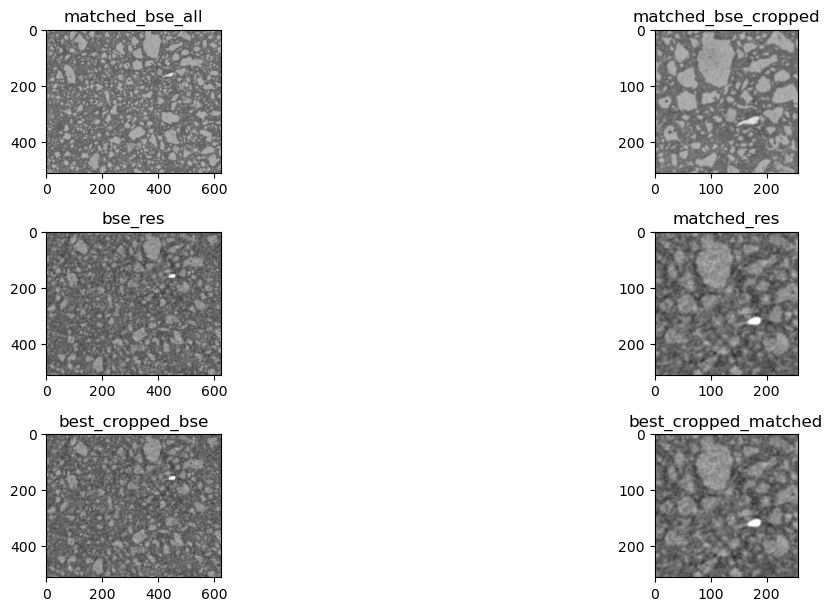

In [4]:
best_ct_img = Tools.get_ct_img(config.cement_sample_index, best_cropped_index)
best_cropped_matched_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_cropped_rect
                                   )
best_cropped_bse_res = Tools.crop_rotate_mi(ct_img, 
                                   [ct_size[0] * 0.5, ct_size[0] * 0.5],
                                   ct_size,
                                   config.matched_rotation,
                                   matched_bse_rect
                                   )

VisualizeData.show_imgs([matched_bse_img, matched_bse_cropped_img, 
                         cropped_bse_res, cropped_matched_res,
                           best_cropped_bse_res, best_cropped_matched_res], 
                           ["matched_bse_all", "matched_bse_cropped", 
                            "bse_res", "matched_res",
                            "best_cropped_bse", "best_cropped_matched"])

In [ ]:
# 三维CT图像坐标映射

import numpy as np

def rotation_matrix_from_euler_angles(angles, order='XYZ'):
    """
    根据欧拉角生成旋转矩阵。
    参数：
    angles -- 欧拉角，长度为 3 的数组，表示绕每个轴的旋转角度
    order -- 旋转顺序，默认为 'XYZ'
    返回：
    rotation_matrix -- 旋转矩阵，形状为 (3, 3)
    """
    theta_x, theta_y, theta_z = angles
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    if order == 'XYZ':
        return np.dot(Rz, np.dot(Ry, Rx))
    elif order == 'ZYX':
        return np.dot(Rx, np.dot(Ry, Rz))
    else:
        raise ValueError("Unsupported rotation order")

# rotation_center：就是切片的中心对应的那个点
# points: 切片
# rotations: (rotation_x, rotation_y, rotation_z)都是角度
def rotate_points(rotation_center, rotations, points):
    # 定义旋转角度（弧度制）
    theta_x = np.radians(rotations[0])  # 绕 x 轴旋转角度
    theta_y = np.radians(rotations[1])  # 绕 y 轴旋转角度
    theta_z = np.radians(rotations[2])  # 绕 z 轴旋转角度

    # 根据欧拉角生成旋转矩阵，固定旋转顺序为 'XYZ'
    rotation_matrix = rotation_matrix_from_euler_angles([theta_x, theta_y, theta_z], order='XYZ')

    translate_2_origin = np.array(rotation_center)

    points_in_origin = points - translate_2_origin
    points_after_rotate = np.dot(points_in_origin, rotation_matrix)

    points_after_transform = points_after_rotate + translate_2_origin

    # 注意这个地方跑出了边界外的处理，需要进行限制，两个方面限制
    # （1）确实就是超出去了怎么办，其中有负值，那么怎么处理，这个地方设置不当容易造成溢出
    # （2）可以事先进行先验的范围设置
    # 这个地方不能直接这样暴力地转换，要进行四舍五入的处理
    points_after_transform = np.round(points_after_transform)
    return points_after_transform.astype(np.uint8)

# 计算距离切片的偏移, size:[width, height]
def compute_offset_from_ct(ct_size, slice_size):
    delta_x = ct_size[0] * .5 - slice_size[0] * .5
    delta_y = ct_size[1] * .5 - slice_size[1] * .5
    return [delta_x, delta_y]

volume_shape = volume.shape

width, height, depth = volume_shape[0], volume_shape[1], volume_shape[2]
slice_width, slice_height = 624, 512

delta = compute_offset_from_ct([width, height], [slice_width, slice_height])

gray_delta = 255 // depth
slice_shape = (width, height)
volume_test = np.zeros((1, width, height), np.int32)

for i in range(depth):
    slice = np.full(slice_shape, (i+1) * gray_delta).reshape((1, width, height))
    volume_test = np.concatenate([volume_test, slice], axis=0)

slice_idx = 7

# 使用 meshgrid 生成网格，然后将其转换为所需格式
x, y = np.meshgrid(np.arange(slice_width), np.arange(slice_height))
# 转置网格坐标，使其符合 [N, M] 的形状
# x = x.T
# y = y.T
# 堆叠坐标网格形成所需的数组
coordinates = np.stack((x, y), axis=-1)
# 创建一个与 coordinates 形状匹配的常量数组
constant_array = np.full(coordinates.shape[:-1] + (1,), slice_idx)
coordinates = coordinates + delta

# 将 coordinates 和 constant_array 连接起来
index_array = np.concatenate((coordinates, constant_array), axis=-1)

rotation_center = index_array[slice_height // 2, slice_width // 2]
print(f"rotation center: {rotation_center}")

# HACK rotation center不对，应该是CT坐标空间下的坐标，现在这个index_array实际上只是一个相对的坐标
index_array = rotate_points(rotation_center, [5, 5, 10], index_array)

print(index_array.shape)
# 通过index_array来进行索引切片
result = volume_test[index_array[..., 2], index_array[..., 0], index_array[..., 1]]

# coord_1 = index_array[0, 0]
# coord_2 = index_array[1, 0]
# coord_3 = index_array[0, 1]
# print(coord_1, coord_2, coord_3)
# shape是[rows, cols]

VisualizeData.show_image(result)
